In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import yfinance as yf
from IPython.display import display



In [17]:

def _infer_freq(idx: pd.DatetimeIndex, prefer_business=True) -> str:
    if idx is None or len(idx) < 3: return "D"
    inferred = pd.infer_freq(idx)
    if inferred is None: return "B" if prefer_business else "D"
    for k in ("B","D","W","M","Q","A","Y"):
        if inferred.startswith(k): return ("Y" if k in ("A","Y") else k)
    return "D"

def _extract_close_series(data: pd.DataFrame, tkr: str) -> pd.Series:
    df = data.copy()
    if not isinstance(df.columns, pd.MultiIndex):
        for cand in ["Close","Adj Close","close","adj close"]:
            if cand in df.columns: return pd.to_numeric(df[cand], errors="coerce")
        lower = {c.lower(): c for c in df.columns}
        if "close" in lower:  return pd.to_numeric(df[lower["close"]], errors="coerce")
        if "adj close" in lower: return pd.to_numeric(df[lower["adj close"]], errors="coerce")
        raise KeyError("No se encontró columna Close/Adj Close en los datos.")
    def has_lv(level_idx, name):
        try: return name in df.columns.get_level_values(level_idx)
        except Exception: return False
    if has_lv(-1,"Close") or has_lv(-1,"Adj Close"):
        try: sub = df.xs("Close", level=-1, axis=1)
        except KeyError: sub = df.xs("Adj Close", level=-1, axis=1)
        sel = tkr if tkr in sub.columns else sub.columns[0]
        return pd.to_numeric(sub[sel], errors="coerce")
    if has_lv(0,"Close") or has_lv(0,"Adj Close"):
        try: sub = df.xs("Close", level=0, axis=1)
        except KeyError: sub = df.xs("Adj Close", level=0, axis=1)
        sel = tkr if tkr in sub.columns else sub.columns[0]
        return pd.to_numeric(sub[sel], errors="coerce")
    raise KeyError("No se pudo localizar la columna de cierre (MultiIndex).")

def _prepare_df_yf(data: pd.DataFrame, ticker: str) -> pd.DataFrame:
    s = _extract_close_series(data, ticker).astype(np.float32)
    ds = pd.to_datetime(s.index).tz_localize(None)
    out = pd.DataFrame({"unique_id": str(ticker), "ds": ds, "y": s.values})
    return out.dropna().sort_values("ds").reset_index(drop=True)

def _ceil_to(x: int, base: int) -> int:
    return int(np.ceil(max(1, x) / float(base)) * base)

def _build_tfm(horizon: int, prefer_gpu: bool, bs: int = 32):
    import torch
    from timesfm import TimesFm, TimesFmHparams, TimesFmCheckpoint
    backend = "gpu" if (prefer_gpu and torch.cuda.is_available()) else "cpu"
    horizon_eff = _ceil_to(horizon, 128)
    hparams = TimesFmHparams(
        backend=backend,
        per_core_batch_size=int(bs),
        input_patch_len=32,
        output_patch_len=128,
        num_layers=50,
        model_dims=1280,
        use_positional_embedding=False,
        context_len=2048,
        horizon_len=horizon_eff,
    )
    ckpt = TimesFmCheckpoint(huggingface_repo_id="google/timesfm-2.0-500m-pytorch")
    return TimesFm(hparams=hparams, checkpoint=ckpt)

def _pick_pred_col(fdf: pd.DataFrame) -> str:
    lc = [c.lower() for c in fdf.columns]
    for target in ["timesfm-q-0.5","timesfm","yhat","forecast","mean"]:
        for i,c in enumerate(lc):
            if c == target: return fdf.columns[i]
    meds = [c for c in fdf.columns if c.lower().endswith("q-0.5")]
    return meds[0] if meds else fdf.columns[-1]


def _plot(hist_df: pd.DataFrame, fc_df: pd.DataFrame, pred_col: str, titulo: str):
    plt.figure(figsize=(12,6))
    sns.lineplot(x="ds", y="y", data=hist_df, label="Reales")
    sns.lineplot(x="ds", y=pred_col, data=fc_df, label="Predicción (TimesFM)")
    plt.title(titulo)
    plt.xlabel("Fecha")
    plt.ylabel("Precio de cierre")
    plt.legend()
    plt.show()

def _r2_score(y_true, y_pred) -> float:
    try:
        from sklearn.metrics import r2_score
        return float(r2_score(y_true, y_pred))
    except Exception:
        y_true = np.asarray(y_true, dtype=float)
        y_pred = np.asarray(y_pred, dtype=float)
        ss_res = np.nansum((y_true - y_pred) ** 2)
        ss_tot = np.nansum((y_true - np.nanmean(y_true)) ** 2)
        return float(1 - ss_res / ss_tot) if ss_tot > 0 else float("nan")

def _plot_eval(test_df: pd.DataFrame, pred_df: pd.DataFrame, pred_col: str, titulo: str):
    plt.figure(figsize=(12,6))
    sns.lineplot(x="ds", y="y", data=test_df, label="Real (test)")
    sns.lineplot(x="ds", y=pred_col, data=pred_df, label="Predicción")
    plt.title(titulo)
    plt.xlabel("Fecha")
    plt.ylabel("Precio de cierre")
    plt.legend()
    plt.show()
    return fig


In [18]:

TOKENS_CRYPTO = [
    ("BTC-USD","Bitcoin"),("ETH-USD","Ethereum"),("BNB-USD","BNB"),
    ("SOL-USD","Solana"),("XRP-USD","XRP"),("DOGE-USD","Dogecoin"),
    ("ADA-USD","Cardano"),("TON-USD","Toncoin"),("DOT-USD","Polkadot"),
    ("AVAX-USD","Avalanche")
]
ACCIONES_EJEMPLO = [
    ("AAPL","Apple"),("MSFT","Microsoft"),("NVDA","NVIDIA"),
    ("AMZN","Amazon"),("GOOGL","Alphabet"),("META","Meta"),
    ("TSLA","Tesla"),("NFLX","Netflix"),("AMD","AMD"),("INTC","Intel")
]


In [19]:

accion = "AAPL"
periodo = "2y"
dias = 30


Fetching 5 files: 100%|██████████| 5/5 [00:00<?, ?it/s]


Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


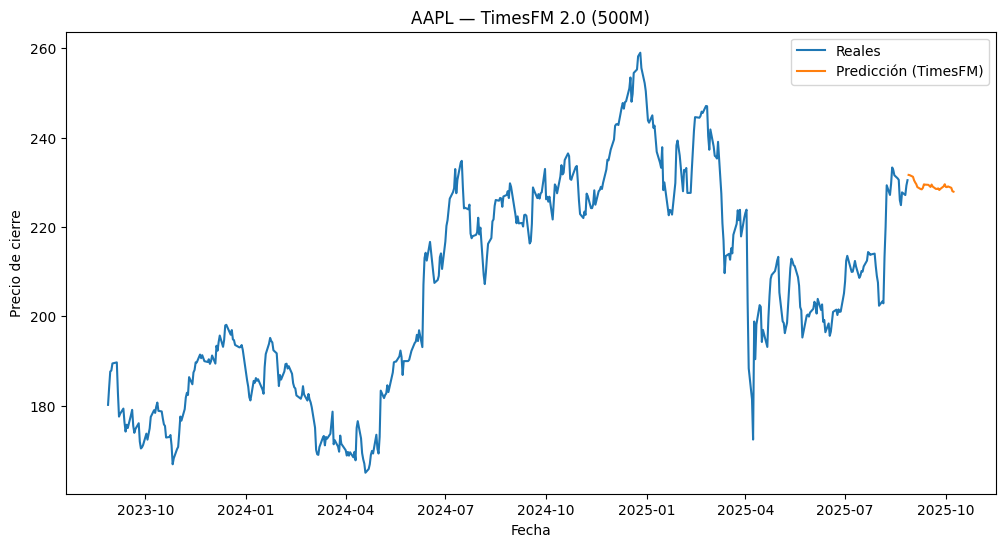

In [20]:

data = yf.download(accion, period=periodo, progress=False, group_by="column", auto_adjust=False, threads=True)
if data is None or data.empty:
    raise RuntimeError("No hay datos para ese ticker/periodo.")
input_df = _prepare_df_yf(data, accion)
freq = _infer_freq(data.index)
tfm = _build_tfm(dias, prefer_gpu=True, bs=32)
fc_df = tfm.forecast_on_df(inputs=input_df, freq=freq, value_name="y", num_jobs=-1)
if "ds" in fc_df.columns: fc_df = fc_df.sort_values("ds")
fc_df = fc_df.iloc[:dias].copy()
pred_col = _pick_pred_col(fc_df)
_plot(input_df, fc_df, pred_col, f"{accion} — TimesFM 2.0 (500M)")

Fetching 5 files: 100%|██████████| 5/5 [00:00<?, ?it/s]


Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


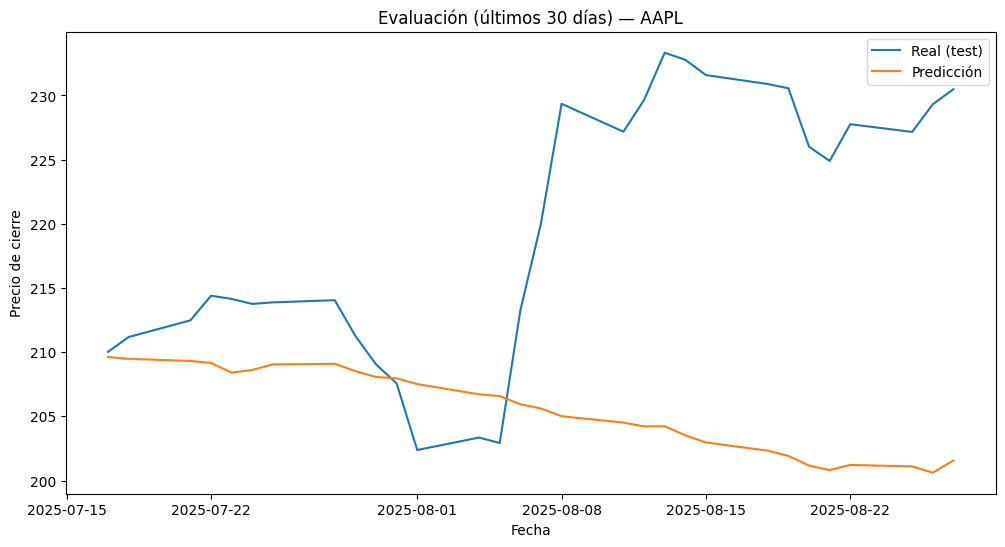

In [25]:

if len(input_df) <= dias + 5:
    r2 = np.nan
else:
    train_df = input_df.iloc[:-dias].copy()
    test_df  = input_df.iloc[-dias:].copy()
    tfm_eval = _build_tfm(dias, prefer_gpu=True, bs=32)
    fc_eval = tfm_eval.forecast_on_df(inputs=train_df, freq=freq, value_name="y", num_jobs=-1)
    if "ds" in fc_eval.columns: fc_eval = fc_eval.sort_values("ds")
    fc_eval = fc_eval.iloc[:dias].copy()
    pred_col_eval = _pick_pred_col(fc_eval)
    merged = pd.merge(test_df[["ds","y"]], fc_eval[["ds", pred_col_eval]], on="ds", how="inner")
    if merged.empty:
        m = min(len(test_df), len(fc_eval))
        merged = pd.DataFrame({
            "ds": test_df["ds"].iloc[:m].values,
            "y":  test_df["y"].iloc[:m].values,
            pred_col_eval: fc_eval[pred_col_eval].iloc[:m].values
        })
    r2 = _r2_score(merged["y"].values, merged[pred_col_eval].values)
    _plot_eval(merged.rename(columns={"y":"y"}),
            merged.rename(columns={pred_col_eval: pred_col_eval}),
            pred_col_eval,
            f"Evaluación (últimos {dias} días) — {accion}")

